# AAA Northeast Customer Clustering

In [51]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plt2

In [2]:
df = pd.read_csv('processed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Columns: 237 entries, Household Key to x5_Young City Solos
dtypes: float64(237)
memory usage: 6.3 MB


In [3]:
df.columns[:30]

Index(['Household Key', 'Member Key count', 'Length Of Residence mean',
       'Do Not Direct Mail Solicit mean', 'Email Available mean',
       'ERS ENT Count Year 1 sum', 'ERS ENT Count Year 1 mean',
       'ERS ENT Count Year 2 sum', 'ERS ENT Count Year 2 mean',
       'ERS ENT Count Year 3 sum', 'ERS ENT Count Year 3 mean',
       'ERS Member Cost Year 1 sum', 'ERS Member Cost Year 1 mean',
       'ERS Member Cost Year 2 sum', 'ERS Member Cost Year 2 mean',
       'ERS Member Cost Year 3 sum', 'ERS Member Cost Year 3 mean',
       'Member Tenure Years mean', 'Cost 2014 sum', 'Cost 2015 sum',
       'Cost 2016 sum', 'Cost 2017 sum', 'Cost 2018 sum', 'Cost 2019 sum',
       'Total Cost sum', 'Mail Responder mean', 'Number of Children mean',
       'Income mean', 'Credit Ranges mean', 'AssociateMember sum'],
      dtype='object')

In [4]:
df = df.rename(columns = {'FSV CMSI Flag': 'FSV CMSI', 
                          'FSV Credit Card Flag': 'FSV Credit Card', 
                          'FSV Deposit Program Flag': 'FSV Deposit Program', 
                          'FSV Home Equity Flag': 'FSV Home Equity',
                          'FSV ID Theft Flag': 'FSV ID Theft',
                          'FSV Mortgage Flag': 'FSV Mortgage',
                          'INS Client Flag': 'INS Client', 
                          'TRV Globalware Flag': 'TRV Globalware',
                          'New Mover Flag': 'New Mover'})

## Data Exploration
### Product Usage
Only a small portion of households using the products. The most used product has lower than 30% of the usage.

In [5]:
product_list = ['FSV CMSI', 'FSV Credit Card', 'FSV Deposit Program', 
                'FSV Home Equity', 'FSV ID Theft', 'FSV Mortgage',
                'INS Client', 'TRV Globalware', 'New Mover']

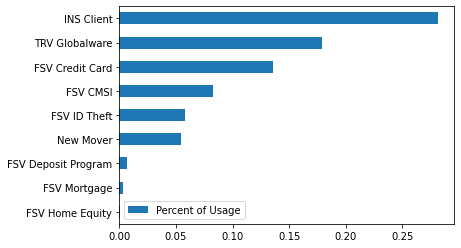

In [6]:
#plt.rcParams["figure.figsize"] = [4,6]
df_product_pct = pd.DataFrame({'Percent of Usage': df[product_list].mean()}
                             ).join(pd.DataFrame({'Count of Usage': df[product_list].sum()}))
df_product_pct[['Percent of Usage']].sort_values(['Percent of Usage']).plot(kind='barh')
plt.show()

Around 45% of the households do not use any products from AAA Northeast.

In [7]:
# Number of products bought by household
df[product_list].sum(axis=1).value_counts()

0.0    1589
1.0    1220
2.0     539
3.0     135
4.0      25
5.0       3
dtype: int64

In [8]:
1589/3511

0.4525776132156081

## Predictive Analysis
We could use classification models to predict the probability of an household buying a product on the products with more than 1% of household usage. The models build on these products should have be better in generalization than other low-usage products.

For all products with over 5% user, apply the following process for modeling:
- Upsampling
- Create training & test set based on upsampled dataset
- Grid search using Decision Tree (Set the max of depth to 10 instead of None to avoid overfitting)
- Apply bagging with 100 estimators using decision tree and best parameters

In [9]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [10]:
%%time
df_prob = pd.DataFrame()
lst_test_auc_dt = []
lst_test_auc = []
lst_total_auc = []
for prod in product_list:
    # Up Sampling
    # Separate majority and minority classes
    df_majority = df[df[prod]==0]
    df_minority = df[df[prod]==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=72) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print('====', prod, '====')
    print(df_upsampled[prod].value_counts())
    
    # X - exclude total costs as it will be used for clustering
    cols = [x for x in df_upsampled.columns if (x not in product_list
                                               ) & (x not in ['Household Key', 'Total Cost sum'])]
    X = df_upsampled[cols]

    # y
    y = df_upsampled[prod]
        
    # Training and testing sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=75)
    
    # Train Decision Tree
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [8, 10, 12],
                  'min_samples_split': [2, 3, 4]}
    
    gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    gs_dt.fit(X_train, y_train)
    print("\n== Decision Tree ==")
    print("Best Parameters:", gs_dt.best_params_)
    print("Accuracy on Training Set:", gs_dt.best_score_)

    y_pred_prob = gs_dt.predict_proba(X_test)[:,1]
    print("Accuracy on Test Set:", gs_dt.score(X_test, y_test), 
          "AUC:", roc_auc_score(y_test, y_pred_prob))
    
    y_pred_prob = gs_dt.predict_proba(df[cols])[:,1]
    test_auc_dt = roc_auc_score(df[prod], y_pred_prob)
    print("Accuracy on Original Dataset:", gs_dt.score(df[cols], df[prod]), 
          "AUC:", test_auc_dt)
    
    # Train Bagging 
    dt = DecisionTreeClassifier(criterion=gs_dt.best_estimator_.criterion,
                                max_depth=gs_dt.best_estimator_.max_depth,
                                min_samples_split=gs_dt.best_estimator_.min_samples_split)
    bg =  BaggingClassifier(dt, n_estimators = 100)
    bg.fit(X_train, y_train)
    print("\n== Decision Tree + Bagging ==")
    print("Accuracy on Training Set:", bg.score(X_train, y_train))

    y_pred_prob = bg.predict_proba(X_test)[:,1]
    test_auc = roc_auc_score(y_test, y_pred_prob)
    print("Accuracy on Test Set:", bg.score(X_test, y_test),
          "AUC:", test_auc)
    
    y_pred_prob = bg.predict_proba(df[cols])[:,1]
    total_auc = roc_auc_score(df[prod], y_pred_prob)
    print("Accuracy on Original Dataset:", bg.score(df[cols], df[prod]),
          "AUC:", total_auc)
    
    # Collect AUC score
    lst_test_auc_dt.append(test_auc_dt)
    lst_test_auc.append(test_auc)
    lst_total_auc.append(total_auc)
    
    # Predict whole dataset
    y_pred = bg.predict(df[cols])
    print("Prediction Count:")
    print(pd.Series(y_pred).value_counts(), "\n")
    
    # Get probability if for non-buyers
    df_prob[prod] = [p if a == 0 else a for p, a in zip(y_pred_prob, df[prod])]

==== FSV CMSI ====
1.0    3221
0.0    3221
Name: FSV CMSI, dtype: int64

== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 2}
Accuracy on Training Set: 0.8616372077255564
Accuracy on Test Set: 0.8626842513576416 AUC: 0.9076279551254274
Accuracy on Original Dataset: 0.8245514098547423 AUC: 0.9405887013028724

== Decision Tree + Bagging ==
Accuracy on Training Set: 0.9625460896565108
Accuracy on Test Set: 0.9262994569433669 AUC: 0.988080793490298
Accuracy on Original Dataset: 0.9441754485901452 AUC: 0.9904527400999903
Prediction Count:
0.0    3049
1.0     462
dtype: int64 

==== FSV Credit Card ====
1.0    3033
0.0    3033
Name: FSV Credit Card, dtype: int64

== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 2}
Accuracy on Training Set: 0.7471162686995021
Accuracy on Test Set: 0.7471169686985173 AUC: 0.8085759494529772
Accuracy on Original Dataset: 0.7413842210196525 AUC: 0.8631928148801123

== 

In [11]:
df_prob.head()

,FSV CMSI,FSV Credit Card,FSV Deposit Program,FSV Home Equity,FSV ID Theft,FSV Mortgage,INS Client,TRV Globalware,New Mover
0,0.190561,1.000000,0.000000,0.00,0.031233,0.02,0.390629,0.338546,1.000000
1,0.109526,0.433309,0.000000,0.00,0.079670,0.00,1.000000,0.288643,0.035584
2,0.100664,0.150313,0.044810,0.00,0.407399,0.00,0.333797,1.000000,0.097397
3,0.158302,0.236559,0.000000,0.00,0.398441,0.00,0.167813,1.000000,0.112228
4,0.635999,0.496385,0.007657,0.08,0.154740,0.00,1.000000,1.000000,0.116006


In [12]:
df_prob.describe()

,FSV CMSI,FSV Credit Card,FSV Deposit Program,FSV Home Equity,FSV ID Theft,FSV Mortgage,INS Client,TRV Globalware,New Mover
count,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000
mean,0.251860,0.396857,0.116888,0.001529,0.272723,0.020857,0.513939,0.445824,0.223734
std,0.268689,0.288650,0.220487,0.030735,0.298996,0.080230,0.314256,0.293324,0.225270
min,0.000828,0.000000,0.000000,0.000000,0.000000,0.000000,0.082785,0.014259,0.005598
25%,0.077739,0.175061,0.000000,0.000000,0.000000,0.000000,0.282004,0.222063,0.089668
50%,0.130718,0.321867,0.000000,0.000000,0.163497,0.000000,0.360646,0.379270,0.144935
75%,0.337408,0.534861,0.083740,0.000000,0.491519,0.000000,1.000000,0.540660,0.262920
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_auc = pd.DataFrame({'Product': product_list,
                       'Test Set AUC (Decision Tree)': lst_test_auc_dt,
                       'Test Set AUC (Bagging)': lst_test_auc,
                       'All Data AUC (Bagging)': lst_total_auc})
df_auc

,Product,Test Set AUC (Decision Tree),Test Set AUC (Bagging),All Data AUC (Bagging)
0,FSV CMSI,0.940589,0.988081,0.990453
1,FSV Credit Card,0.863193,0.960312,0.973901
2,FSV Deposit Program,0.952041,0.999826,0.999489
3,FSV Home Equity,1.000000,1.000000,1.000000
4,FSV ID Theft,0.879789,0.993578,0.994840
5,FSV Mortgage,0.997532,1.000000,1.000000
6,INS Client,0.808597,0.887416,0.953598
7,TRV Globalware,0.791115,0.944751,0.965058
8,New Mover,0.923843,0.994547,0.997655


[]

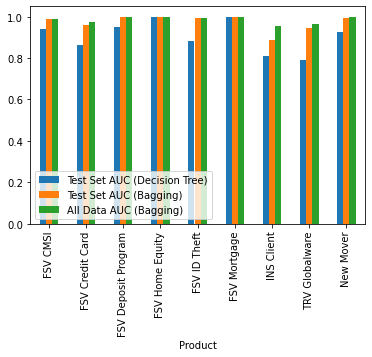

In [76]:
# Plot AUC
df_auc.plot(x='Product', y=['Test Set AUC (Decision Tree)', 
                            'Test Set AUC (Bagging)', 
                            'All Data AUC (Bagging)'], kind='bar')
plt.legend(loc='lower left')
plt.plot()

In [15]:
df_auc.mean()

Test Set AUC (Decision Tree)    0.906300
Test Set AUC (Bagging)          0.974279
All Data AUC (Bagging)          0.986110
dtype: float64

**With high AUC on predicting all products in the original dataset, we can be confident that the probability of purchsing would be a good reference on current and potential buyers of each product.**

## Predict Cost in Next 12 Months
We can use the cost before year 2019 as year n-1, n-2, and so on to predict the cost in year 2019. Afterwards, we can use treat year 2019 as year n-1, year 2018 as year n-2, and so on to preduct the cost in year 2020. 

Based on the difinition, ERS ENT Count Year 1 and ERS Member Cost Year 1 happen in year 2019, so we can't use them to predict the cost in 2019. However, they can be used to predict the cost in 2020.

One assumption here is that the household info would remain the same in year 2020 as we don't have the projected household info of year 2020.

In [16]:
df_cost_prediction = df.drop(['Household Key', 'Total Cost sum', 
                              'ERS ENT Count Year 1 sum', 'ERS ENT Count Year 1 mean',
                              'ERS ENT Count Year 2 mean', 'ERS ENT Count Year 3 mean', 
                              'ERS Member Cost Year 1 sum', 'ERS Member Cost Year 1 mean',
                              'ERS Member Cost Year 2 mean', 'ERS Member Cost Year 3 mean'
                             ] + product_list, axis = 1)
    # Categorical variables
cat_cols = [x for x in df_cost_prediction.columns if x.startswith('x')]
for col in cat_cols:
    df_cost_prediction[col] = df_cost_prediction[col].astype('category')
df_cost_prediction = df_cost_prediction.rename(columns = 
                                               {'Cost 2018 sum': 'Cost n-1',
                                                'Cost 2017 sum': 'Cost n-2',
                                                'Cost 2016 sum': 'Cost n-3',
                                                'Cost 2015 sum': 'Cost n-4',
                                                'Cost 2014 sum': 'Cost n-5',
                                                'ERS ENT Count Year 2 sum': 'ERS ENT Count Year n-1',
                                                'ERS ENT Count Year 3 sum': 'ERS ENT Count Year n-2',
                                                'ERS Member Cost Year 2 sum': 'ERS Member Cost Year n-1',
                                                'ERS Member Cost Year 3 sum': 'ERS Member Cost Year n-2'})
df_cost_prediction.iloc[:, :25].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Member Key count                 3511 non-null   float64 
 1   Length Of Residence mean         3511 non-null   float64 
 2   Do Not Direct Mail Solicit mean  3511 non-null   float64 
 3   Email Available mean             3511 non-null   float64 
 4   ERS ENT Count Year n-1           3511 non-null   float64 
 5   ERS ENT Count Year n-2           3511 non-null   float64 
 6   ERS Member Cost Year n-1         3511 non-null   float64 
 7   ERS Member Cost Year n-2         3511 non-null   float64 
 8   Member Tenure Years mean         3511 non-null   float64 
 9   Cost n-5                         3511 non-null   float64 
 10  Cost n-4                         3511 non-null   float64 
 11  Cost n-3                         3511 non-null   float64 
 12  Cost n

In [17]:
df_cost_prediction.head()

,Member Key count,Length Of Residence mean,Do Not Direct Mail Solicit mean,Email Available mean,ERS ENT Count Year n-1,ERS ENT Count Year n-2,ERS Member Cost Year n-1,ERS Member Cost Year n-2,Member Tenure Years mean,Cost n-5,...,x5_Middle Class Melting Pot,x5_Not Set,x5_Pastoral Pride,x5_Power Elite,x5_Promising Families,x5_Significant Singles,x5_Singles and Starters,x5_Surburban Style,x5_Thriving Boomers,x5_Young City Solos
0,0.0,14.000000,0.0,0.500000,1.0,4.0,58.85,347.16,32.500000,243.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,14.000000,0.0,0.750000,2.0,3.0,156.85,301.19,35.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,15.000000,0.0,1.000000,0.0,0.0,0.00,0.00,13.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,13.333333,0.0,1.000000,5.0,3.0,277.90,159.00,38.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,15.000000,0.0,0.333333,0.0,0.0,0.00,0.00,27.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


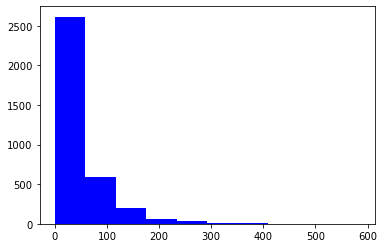

In [71]:
plt.hist(df_cost_prediction['Cost 2019 sum'], bins=10, color = 'blue')
plt.show()

In [22]:
df_cost_prediction['Cost 2019 sum'].describe()

count    3511.000000
mean       29.002273
std        55.264674
min         0.000000
25%         0.000000
50%         0.000000
75%        58.850000
max       584.170000
Name: Cost 2019 sum, dtype: float64

In [65]:

plt.hist2d (ima, gra, bins=df_cost_prediction['Cost 2019 sum'], cmap='Greys')

NameError: name 'ima' is not defined

In [23]:
# Percentage of households with costs greater than 0 in 2019
len(df_cost_prediction['Cost 2019 sum'
                      ][df_cost_prediction['Cost 2019 sum'
                                          ] > 0]) / len(df_cost_prediction['Cost 2019 sum'])

0.3383651381372828

**The majority of households didn't generate any costs in 2019. Therefore, the question is modified to a classification question to identify the probability of a household generating cost in 2020**

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
X = df_cost_prediction.drop(['Cost 2019 sum'], axis=1)
# y = df_cost_prediction[['Cost 2019 sum']]
y = [1 if x > 0 else 0 for x in df_cost_prediction['Cost 2019 sum']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 28)

In [26]:
%%time
param_grid = {'C': [15-6, 1e-5, 1e-4], 
              'tol': [10, 1, 0.1], 
              'max_iter': [1000, 1500]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs_lr.fit(X_train, y_train)
print("Best Parameters:", gs_lr.best_params_)
print("Accuracy on Training Set:", gs_lr.best_score_)

y_pred_prob = gs_lr.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_lr.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

y_pred_prob = gs_lr.predict_proba(X)[:,1]
print(#"Accuracy on Original Dataset:", bg.score(X, y),
      "AUC on Original Dataset:", roc_auc_score(y, y_pred_prob))

Best Parameters: {'C': 9, 'max_iter': 1000, 'tol': 10}
Accuracy on Training Set: 0.7285281406785555
Accuracy on Test Set: 0.7609108159392789
AUC: 0.7649971185677809
AUC on Original Dataset: 0.7772911349105925
Wall time: 24.3 s


In [27]:
y_pred = gs_lr.predict(X_test)
pd.Series(y_pred).value_counts()

0    869
1    185
dtype: int64

In [28]:
%%time
# Train Decision Tree
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 4]}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
gs_dt.fit(X_train, y_train)
print("\n== Decision Tree ==")
print("Best Parameters:", gs_dt.best_params_)
print("Accuracy on Training Set:", gs_dt.best_score_)

y_pred_prob = gs_dt.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_dt.score(X_test, y_test), 
      "AUC:", roc_auc_score(y_test, y_pred_prob))
    
y_pred_prob = gs_dt.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", gs_dt.score(X, y), 
      "AUC:", roc_auc_score(y, y_pred_prob))

# Train Bagging 
dt = DecisionTreeClassifier(criterion=gs_dt.best_estimator_.criterion,
                            max_depth=gs_dt.best_estimator_.max_depth,
                            min_samples_split=gs_dt.best_estimator_.min_samples_split)
bg =  BaggingClassifier(dt, n_estimators = 100)
bg.fit(X_train, y_train)
print("\n== Bagging ==")
print("Accuracy on Training Set:", bg.score(X_train, y_train))

y_pred_prob = bg.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", bg.score(X_test, y_test),
      "AUC:", roc_auc_score(y_test, y_pred_prob))
    
y_pred_prob = bg.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", bg.score(X, y),
      "AUC:", roc_auc_score(y, y_pred_prob))
    
y_pred = bg.predict(X)
print("Prediction Count:")
print(pd.Series(y_pred).value_counts(), "\n")


== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Accuracy on Training Set: 0.7492805457586144
Accuracy on Test Set: 0.7637571157495257 AUC: 0.7615898775496469
Accuracy on Original Dataset: 0.7630304756479636 AUC: 0.7779692824354899

== Bagging ==
Accuracy on Training Set: 0.7643467643467643
Accuracy on Test Set: 0.7703984819734345 AUC: 0.7763083174539076
Accuracy on Original Dataset: 0.7661634861862717 AUC: 0.8018383360075139
Prediction Count:
0    2408
1    1103
dtype: int64 

Wall time: 19 s


In [29]:
df_2020_prediction = df.drop(['Household Key','Cost 2014 sum', 'Total Cost sum', 
                              'ERS ENT Count Year 3 sum', 'ERS ENT Count Year 1 mean',
                              'ERS ENT Count Year 2 mean', 'ERS ENT Count Year 3 mean', 
                              'ERS Member Cost Year 3 sum', 'ERS Member Cost Year 1 mean',
                              'ERS Member Cost Year 2 mean', 'ERS Member Cost Year 3 mean'
                             ] + product_list, axis = 1)
    # Categorical variables
cat_cols = [x for x in df_2020_prediction.columns if x.startswith('x')]
for col in cat_cols:
    df_cost_prediction[col] = df_cost_prediction[col].astype('category')
df_2020_prediction = df_2020_prediction.rename(columns=
                                               {'Cost 2019 sum': 'Cost n-1',
                                                'Cost 2018 sum': 'Cost n-2',
                                                'Cost 2017 sum': 'Cost n-3',
                                                'Cost 2016 sum': 'Cost n-4',
                                                'Cost 2015 sum': 'Cost n-5',
                                                'ERS ENT Count Year 1 sum': 'ERS ENT Count Year n-1',
                                                'ERS ENT Count Year 2 sum': 'ERS ENT Count Year n-2',
                                                'ERS Member Cost Year 1 sum': 'ERS Member Cost Year n-1',
                                                'ERS Member Cost Year 2 sum': 'ERS Member Cost Year n-2'})
df_2020_prediction.iloc[:, :25].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Member Key count                 3511 non-null   float64
 1   Length Of Residence mean         3511 non-null   float64
 2   Do Not Direct Mail Solicit mean  3511 non-null   float64
 3   Email Available mean             3511 non-null   float64
 4   ERS ENT Count Year n-1           3511 non-null   float64
 5   ERS ENT Count Year n-2           3511 non-null   float64
 6   ERS Member Cost Year n-1         3511 non-null   float64
 7   ERS Member Cost Year n-2         3511 non-null   float64
 8   Member Tenure Years mean         3511 non-null   float64
 9   Cost n-5                         3511 non-null   float64
 10  Cost n-4                         3511 non-null   float64
 11  Cost n-3                         3511 non-null   float64
 12  Cost n-2            

In [30]:
df_prob['Cost'] = bg.predict_proba(df_2020_prediction)[:,1]
y_pred = bg.predict(df_2020_prediction)
print("Prediction Count:")
print(pd.Series(y_pred).value_counts())

Prediction Count:
0    3271
1     240
dtype: int64


In [31]:
df_prob.head()

,FSV CMSI,FSV Credit Card,FSV Deposit Program,FSV Home Equity,FSV ID Theft,FSV Mortgage,INS Client,TRV Globalware,New Mover,Cost
0,0.190561,1.000000,0.000000,0.00,0.031233,0.02,0.390629,0.338546,1.000000,0.489472
1,0.109526,0.433309,0.000000,0.00,0.079670,0.00,1.000000,0.288643,0.035584,0.414233
2,0.100664,0.150313,0.044810,0.00,0.407399,0.00,0.333797,1.000000,0.097397,0.134657
3,0.158302,0.236559,0.000000,0.00,0.398441,0.00,0.167813,1.000000,0.112228,0.444123
4,0.635999,0.496385,0.007657,0.08,0.154740,0.00,1.000000,1.000000,0.116006,0.392975


## Clustering

In [32]:
from sklearn.cluster import KMeans

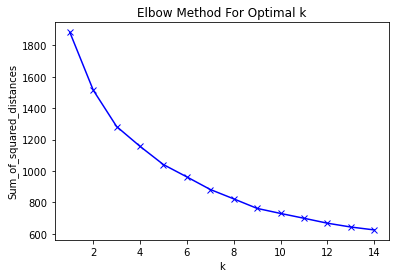

In [33]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_prob.iloc[:,:9])
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [34]:
df_prob = df_prob[['INS Client', 'TRV Globalware', 'FSV Credit Card', 
                   'FSV CMSI', 'FSV ID Theft', 'New Mover', 
                   'FSV Deposit Program', 'FSV Mortgage', 'FSV Home Equity',
                   'Cost']]

kmeans = KMeans(n_clusters= 8, random_state=32).fit(df_prob.iloc[:,:9])
df_prob['Cluster'] = kmeans.labels_
df_prob.head()

,INS Client,TRV Globalware,FSV Credit Card,FSV CMSI,FSV ID Theft,New Mover,FSV Deposit Program,FSV Mortgage,FSV Home Equity,Cost,Cluster
0,0.390629,0.338546,1.000000,0.190561,0.031233,1.000000,0.000000,0.02,0.00,0.489472,7
1,1.000000,0.288643,0.433309,0.109526,0.079670,0.035584,0.000000,0.00,0.00,0.414233,0
2,0.333797,1.000000,0.150313,0.100664,0.407399,0.097397,0.044810,0.00,0.00,0.134657,6
3,0.167813,1.000000,0.236559,0.158302,0.398441,0.112228,0.000000,0.00,0.00,0.444123,6
4,1.000000,1.000000,0.496385,0.635999,0.154740,0.116006,0.007657,0.00,0.08,0.392975,6


In [35]:
df_prob['Cluster'].value_counts().sort_index()

0     482
1     283
2     441
3     363
4    1050
5     367
6     335
7     190
Name: Cluster, dtype: int64

Wall time: 290 ms


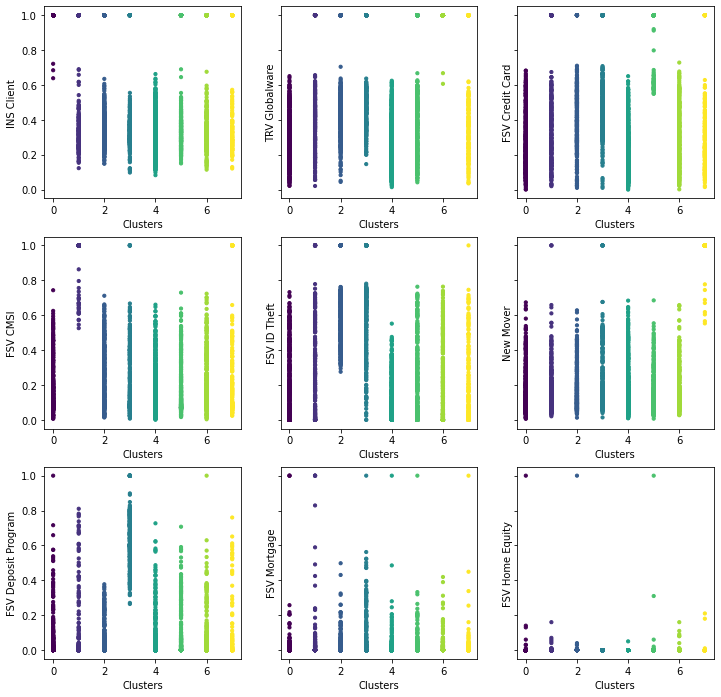

In [78]:
%%time
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharey=True)

col = 0
for i in range(3):
    for j in range(3):
        axs[i, j].scatter(df_prob['Cluster'], df_prob.iloc[:, col], 
                          c=df_prob['Cluster'], cmap='viridis', s=10)
        axs[i, j].set_ylabel(df_prob.iloc[:, col].name)
        axs[i, j].set_xlabel('Clusters')
        col += 1

In [ ]:
# import seaborn as sns

In [ ]:
# sns.pairplot(data = df_prob,
#              x_vars = ['Cluster'],
#              y_vars=['INS Client', 'TRV Globalware', 'FSV Credit Card', 
#                    'FSV CMSI', 'FSV ID Theft', 'New Mover', 
#                    'FSV Deposit Program', 'FSV Mortgage', 'FSV Home Equity',
#                    'Cost'], 
#              hue='Cluster')
# plt.show()

### Clustering Summary

#### Number of Clusters
- From the chart, it seems 3 or 6 clusters are the optimal choices, but 6 or less clusters don't actually reveal much product-level insights for business action.


- When the households are clustered into **8 or 9 groups**, we can identify target audiences that shows high interest on a particular product for 7 products. 


- Clustering observation:
    - 6 clusters -> target segment identified for 4 products
    - 7 clusters -> target segment identified for 5 products
    - 8 clusters -> target segment identified for 7 products
    - 9 clusters -> target segment identified for 7 products

#### Segmentation by Product
- The two products that do not have a particular cluster standing out are FSV Mortgage and FSV Home Equity, which also have the lowest market peneratration. In general, the probability to purchase these two products are very low for all households. For these two products, we could simply focus on individual households with relatively higher probability of purchasing instead of a particular group.


- Segment to product mapping:
    - INS Client: Segment 0
    - TRV Globalware: Segment 1
    - FSV Credit Card: Segment 2
    - FSV CMSI: Segment 7
    - FSV ID Theft: Segment 4
    - New Mover': Segment 5
    - FSV Deposit Program: 6

In [37]:
segments= {'INS Client': 0,
           'TRV Globalware': 1,
           'FSV Credit Card': 2,
           'FSV CMSI': 7,
           'FSV ID Theft': 4,
           'New Mover': 5,
           'FSV Deposit Program': 6}
lst_product = []
lst_HH_size = []
lst_prob_target = []
lst_prob_non_target = []
for k in segments:
    df_target = df_prob[(df_prob['Cluster'] == segments[k]) & (df_prob[k] != 1)]
    df_non_target = df_prob[(df_prob['Cluster'] != segments[k])]
    
    lst_product.append(k)
    lst_HH_size.append(len(df_target))
    lst_prob_target.append(df_target[k].mean())
    lst_prob_non_target.append(df_non_target[k].mean())
    
df_segment_summary = pd.DataFrame({'Product': lst_product,
                                   'Targeted Household Size': lst_HH_size,
                                   'Avg Prob. of Purchase (Target HHs)': lst_prob_target,
                                   'Avg Prob. of Purchase (Non Target HHs)': lst_prob_non_target})
df_segment_summary

,Product,Targeted Household Size,Avg Prob. of Purchase (Target HHs),Avg Prob. of Purchase (Non Target HHs)
0,INS Client,3,0.681484,0.436908
1,TRV Globalware,221,0.375318,0.440008
2,FSV Credit Card,419,0.393239,0.393029
3,FSV CMSI,166,0.197688,0.249161
4,FSV ID Theft,1050,0.067047,0.360476
5,New Mover,367,0.158279,0.231375
6,FSV Deposit Program,334,0.067113,0.121844



                   
#### Cost
- In addition, predicted cost does not have any noticeable difference across clusters, partly because cost is hard to predict. The cost could possibly be generated randomly as a customer only needs it in emergency.

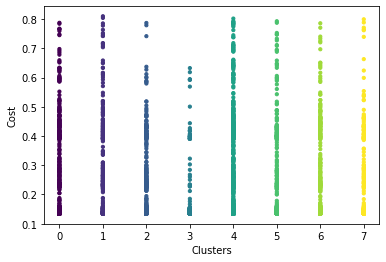

In [38]:
plt.scatter(df_prob['Cluster'], df_prob['Cost'], 
            c=df_prob['Cluster'], cmap='viridis', s=10)
plt.ylabel('Cost')
plt.xlabel('Clusters')
plt.show()

## Appendix
Applying other models - using 'INS Client' as an example.

In [39]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [40]:
# Up Sampling
# Separate majority and minority classes
df_majority = df[df['INS Client']==0]
df_minority = df[df['INS Client']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, 
                                 n_samples=len(df_majority), random_state=72)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
cols = [x for x in df_upsampled.columns if (x not in product_list
                                           ) & (x not in ['Household Key', 'Total Cost sum'])]

X = df_upsampled[cols]
# Scale 
scaler = MinMaxScaler()
scaler.fit(X)
df_scaled = scaler.transform(X)

y = df_upsampled['INS Client']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=75)

#### kNN

In [41]:
%%time
param_grid = {'n_neighbors': np.arange(8, 20)}
gs_kNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
gs_kNN.fit(X_train, y_train)
print("Best Number of Neighbors:", gs_kNN.best_params_)
print("Accuracy on Training Set:", gs_kNN.best_score_)

y_pred_prob = gs_kNN.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_kNN.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Number of Neighbors: {'n_neighbors': 9}
Accuracy on Training Set: 0.5890954151177199
Accuracy on Test Set: 0.5966303270564915
AUC: 0.6268800094295144
Wall time: 28.7 s


#### Logistic Regression

In [42]:
%%time
param_grid = {'C': [15-6, 1e-5, 1e-4], 
              'tol': [10, 1, 0.1], 
              'max_iter': [1000, 1500]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs_lr.fit(X_train, y_train)
print("Best Parameters:", gs_lr.best_params_)
print("Accuracy on Training Set:", gs_lr.best_score_)

y_pred_prob = gs_lr.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_lr.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Parameters: {'C': 1e-05, 'max_iter': 1000, 'tol': 10}
Accuracy on Training Set: 0.5568773234200742
Accuracy on Test Set: 0.55599603567889
AUC: 0.5666234480590917
Wall time: 26 s


#### SVM
SVM takes too much time to train.

#### Random Forest

In [43]:
%%time
param_grid = {'n_estimators':[50, 100, 150],
              'max_depth': [3, 5], 
              'max_features': ['auto', 'sqrt']}
rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid, cv=5)
gs_rf.fit(X_train, np.ravel(y_train))
print("Best Parameters:", gs_rf.best_params_)
print("Accuracy on Training Set:", gs_rf.best_score_)

y_pred_prob = gs_rf.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_rf.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Parameters: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}
Accuracy on Training Set: 0.6014869888475836
Accuracy on Test Set: 0.6065411298315163
AUC: 0.6523239823982399
Wall time: 21.7 s


In [44]:
y_pred = gs_rf.predict(X_test)
pd.Series(y_pred).value_counts()

0.0    576
1.0    433
dtype: int64